In [1]:
import sys
import pandas as pd
import numpy as np
sys.path.insert(0,"../tools")
import geo 
from corr import lensingPCF
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table

Apply magnitude cut to mocks. The mag_i cut, which was originally 19.9 was switch toward higher magnitude such that the number of CMASS galaxies is high enought to measure wg+

In [2]:
df = pd.read_parquet("/Users/rpaviot/Downloads/11334.parquet")
mag_g = (-2.5*np.log10(df['sdss_g']) - 48.6)
mag_r = (- 2.5*np.log10(df['sdss_r']) - 48.6)
mag_i= (- 2.5*np.log10(df['sdss_i']) - 48.6)
mag_z= (- 2.5*np.log10(df['sdss_z']) - 48.6)
dperp = (mag_r - mag_i) - (mag_g - mag_r)/8


cut1 = mag_r - mag_i > 0.98
cut2 = mag_i - mag_z > 0.60
cut3 = ((mag_i > 21.0)  & (mag_i < 22.8))

cond = cut1 & cut2 & cut3

cut4 = dperp > 0.55
cut5 = mag_i < 20.86 + 1.6*(dperp-0.8)
cut6 = mag_i < 21.0

cond2 = cut4 & cut5 & cut6

df2 = df[cond2]
df = df[cond]

ra = df.ra_mag_gal.values
dec = df.dec_mag_gal.values
z = df.observed_redshift_gal.values
g1 = df.eps1_gal.values
g2 = df.eps2_gal.values

ra2 = df2.ra_mag_gal.values
dec2 = df2.dec_mag_gal.values
z2 = df2.observed_redshift_gal.values
g12 = df2.eps1_gal.values
g22 = df2.eps2_gal.values

del df,df2
del mag_g,mag_r,mag_i,mag_z



SC8 footprint

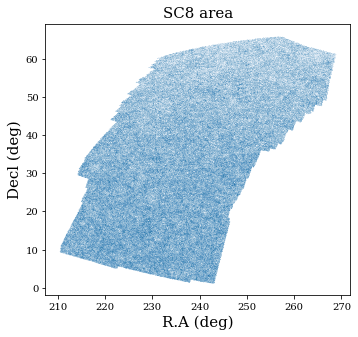

In [3]:
plt.rc('font',family='serif')
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2)
gs.update(hspace=0 ,wspace=0.2)
ax = fig.add_subplot(gs[0])

ax.set_xlabel("R.A (deg)",fontsize=15)
ax.set_ylabel("Decl (deg)",fontsize=15)
ax.set_title('SC8 area',fontsize=15)

plt.scatter(ra,dec,s=0.0001)

treecorr chunks

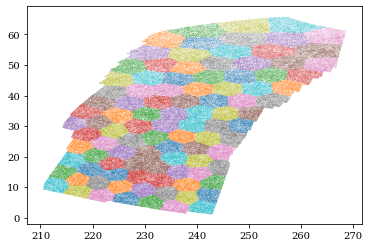

In [12]:
import treecorr

data = treecorr.Catalog(ra=ra,dec=dec,ra_units="degree",dec_units="degree",npatch=100)
patches = np.unique(data.patch)

for i in range(0,len(patches)):
    cond = np.where(data.patch == patches[i])[0]
    rat = data.ra[cond]
    dect = data.dec[cond]
    plt.scatter(rat*180/np.pi,dect*180/np.pi,s=0.0001)

dndr of LRG and CMASS 

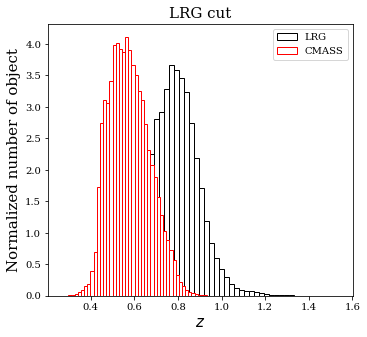

In [6]:
plt.rc('font',family='serif')
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2)
gs.update(hspace=0 ,wspace=0.2)
ax = fig.add_subplot(gs[0])


ax.set_xlabel(r"$z$",fontsize=15)
ax.set_ylabel("Normalized number of object",fontsize=15)
ax.set_title('LRG cut',fontsize=15)

_=plt.hist(z,bins=50,density=True,align='left',color="white",edgecolor="black",label="LRG")
_=plt.hist(z2,density=True,bins=50,align='left',color="white",edgecolor="red",label="CMASS")
ax.legend()


0.04079914093017578
884282 14154689 16.00698532820978


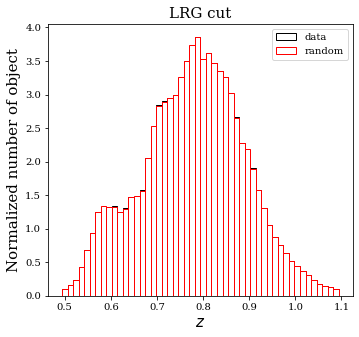

In [7]:
cond = np.where((z > 0.5) & (z < 1.1))
ra = ra[cond]
z = z[cond]
dec = dec[cond]
e1= g1[cond]
e2= g2[cond]

"""Create random catalog for eBOSS LRG"""

footprint = geo.survey_geometry(NSIDE=512,RA=ra,DEC=dec,Z=z,W=np.ones(len(ra)))
ra_rand,dec_rand,z_rand,w_rand = footprint.create_random(1e7)
print(ra.size,ra_rand.size,ra_rand.size/ra.size)
del footprint

plt.rc('font',family='serif')
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2)
gs.update(hspace=0 ,wspace=0.2)
ax = fig.add_subplot(gs[0])


ax.set_xlabel(r"$z$",fontsize=15)
ax.set_ylabel("Normalized number of object",fontsize=15)
ax.set_title('LRG cut',fontsize=15)

_=plt.hist(z,bins=50,density=True,align='left',color="white",edgecolor="black",label="data")
_=plt.hist(z_rand,density=True,bins=50,align='left',color="white",edgecolor="red",label="random")
ax.legend()


In [8]:
"""save data for calculation on clusters"""

w = np.ones(len(ra))
T = Table([ra,dec,z,w,-e1,-e2],names=('ra','dec','z','w','g1','g2'))
T_rand = Table([ra_rand,dec_rand,z_rand,np.ones(len(ra_rand))],names=('ra','dec','z','w'))
T.write('eBOSS_LRG_flagship.fits',format='fits',overwrite=True)
T_rand.write('eBOSS_LRGr_flagship.fits',format='fits',overwrite=True)

clustering, errors might be under-estimated

In [14]:
r,meanr,meanglogr,xi,err = np.loadtxt("./../wgp_CMASS_flagship_jack_final.dat").T
cov = np.loadtxt("./../cov_wgp_CMASS_flagship_jack_final.dat")

In [13]:
r3,meanr,meanlogr,xi3,err3 = np.loadtxt("./../wgp_LRG_flagship_jack.dat").T

Text(0, 0.5, '$\\it{w}_{g+}$[Mpc/h]')

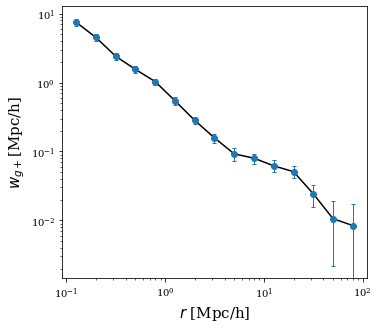

In [15]:
plt.rc('font',family='serif')
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(1, 2)
gs.update(hspace=0 ,wspace=0.2)
ax = fig.add_subplot(gs[0])
ax.set_xscale('log')
ax.set_yscale('log')
plt.errorbar(r,xi,fmt="o",yerr=np.sqrt(np.diag(cov)),capthick=1,elinewidth=1,capsize=2,zorder=10)
plt.plot(r,xi,color="black")
ax.set_xlabel(r'$r $ [Mpc/h]',fontsize=15)
ax.set_ylabel(r'$\it{w}_{g+}$[Mpc/h]',fontsize=15)
